1. Import Libary

In [22]:
from datetime import datetime, timedelta, date
import pandas as pd
import pyodbc 
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, event, types
import urllib # Import riêng thư viện urllib

2. Import Data Frame From SQL SERVER

In [5]:
# ==========================================
# 1. THIẾT LẬP KẾT NỐI
# ==========================================
server = 'DESKTOP-MV8RPS5'
database = 'VTI'
source_table = 'final_project'       # Bảng gốc bạn đã import thủ công
target_table = 'final_project_cleaned' # Bảng mới sau khi đã clean

connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
    f"TrustServerCertificate=yes;"
)

params = urllib.parse.quote_plus(connection_string)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# ==========================================
# 2. LOAD DỮ LIỆU TỪ SQL VÀO PYTHON (Định nghĩa lại df_final_project)
# ==========================================
print("Đang tải dữ liệu từ SQL Server...")
query = f"SELECT * FROM [dbo].[{source_table}]"
df_final_project = pd.read_sql(query, engine)
print(f"Đã tải xong: {df_final_project.shape}")

# ==========================================
# 3. KÍCH HOẠT CHẾ ĐỘ SIÊU TỐC (FAST_EXECUTEMANY)
# ==========================================
@event.listens_for(engine, "connect")
def receive_connect(dbapi_connection, connection_record):
    cursor = dbapi_connection.cursor()
    cursor.fast_executemany = True
    cursor.close()

# ==========================================
# 4. ĐỊNH NGHĨA KIỂU DỮ LIỆU ĐỂ CHỐNG LỖI TRUNCATION
# ==========================================
dtype_dict = {}
long_text_cols = ['devtype', 'languageworkedwith', 'platformworkedwith', 'ethnicity', 'devenviron']

for col in df_final_project.columns:
    if col.lower() in long_text_cols:
        # Ép kiểu NVARCHAR(MAX)
        dtype_dict[col] = types.NVARCHAR(length=None) 

# ==========================================
# 5. ĐẨY DỮ LIỆU NGƯỢC LẠI SQL
# ==========================================
print(f"Đang đẩy {len(df_final_project)} dòng vào bảng {target_table}...")

try:
    df_final_project.to_sql(
        name=target_table, 
        con=engine, 
        if_exists='replace', 
        index=False, 
        dtype=dtype_dict,
        chunksize=None 
    )
    print(f"--- THÀNH CÔNG! Đã lưu vào bảng: {target_table} ---")
except Exception as e:
    print(f"--- THẤT BẠI! Lỗi: {e} ---")

Đang tải dữ liệu từ SQL Server...
Đã tải xong: (11552, 85)
Đang đẩy 11552 dòng vào bảng final_project_cleaned...
--- THÀNH CÔNG! Đã lưu vào bảng: final_project_cleaned ---


3. CLEARNING DATA PROCESS


3.1 Standardization & Handle Missing Value

In [7]:
# 1. Ép kiểu cột Lương (ConvertedComp) về dạng số
df_final_project['ConvertedComp'] = pd.to_numeric(df_final_project['ConvertedComp'], errors='coerce')

# 2. Xử lý thiếu hụt: Dùng Median cho Lương vì lương có độ lệch cực lớn
df_final_project['ConvertedComp'] = df_final_project['ConvertedComp'].fillna(df_final_project['ConvertedComp'].median())

# 3. Xử lý thiếu hụt: Các cột phân loại (Category)
categorical_cols = ['Gender', 'EdLevel', 'Country', 'DevType']
for col in categorical_cols:
    df_final_project[col] = df_final_project[col].fillna('Not specified')

# 4. Xử lý cột Năm kinh nghiệm (YearsCode) - Chuyển chữ thành số
df_final_project['YearsCode'] = df_final_project['YearsCode'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
df_final_project['YearsCode'] = pd.to_numeric(df_final_project['YearsCode'], errors='coerce').fillna(0)

# 5. Xóa trùng lặp
df_final_project.drop_duplicates(inplace=True)

print(f"Kích thước sau khi làm sạch: {df_final_project.shape}")

Kích thước sau khi làm sạch: (11398, 85)


3.2 Check logic (Business Logic) & Outliers

In [8]:
# 1. Lọc tuổi hợp lệ (ví dụ từ 15 đến 90 tuổi)
df_final_project = df_final_project[(df_final_project['Age'] >= 15) & (df_final_project['Age'] <= 90)]

# 2. Năm kinh nghiệm không được lớn hơn (Tuổi - 10)
df_final_project = df_final_project[df_final_project['YearsCode'] <= (df_final_project['Age'] - 10)]

3.3 Detect & Remove Outliers

In [9]:
Q1 = df_final_project['ConvertedComp'].quantile(0.25)
Q3 = df_final_project['ConvertedComp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_final_project = df_final_project[(df_final_project['ConvertedComp'] >= lower_bound) & (df_final_project['ConvertedComp'] <= upper_bound)]

print(f"Kích thước sau khi làm sạch: {df_final_project.shape}")

Kích thước sau khi làm sạch: (9928, 85)


3.4 Feature Engineering

In [10]:
# Cột LanguageWorkedWith có dạng Java;Python;
# C++. Chúng ta cần biết mỗi dòng có bao nhiêu ngôn ngữ.

# Đếm số lượng ngôn ngữ mỗi người biết
df_final_project['LanguageCount'] = df_final_project['LanguageWorkedWith'].apply(lambda x: len(str(x).split(';')) if pd.notnull(x) else 0)

# Chuẩn hóa tên cột về chữ thường và snake_case (giống sườn bài cũ của bạn)
df_final_project.columns = [col.lower().replace(' ', '_') for col in df_final_project.columns]

4. Save Clean Data to SQL Server

In [12]:
@event.listens_for(engine, "connect")
def receive_connect(dbapi_connection, connection_record):
    cursor = dbapi_connection.cursor()
    cursor.fast_executemany = True
    cursor.close()

dtype_dict = {col: types.NVARCHAR(length=None) for col in df_final_project.columns 
              if col.lower() in ['devtype', 'languageworkedwith', 'platformworkedwith', 'ethnicity', 'devenviron']}

print(f"Đang đẩy {len(df_final_project)} dòng dữ liệu ĐÃ SẠCH vào bảng {target_table}...")

try:
    df_final_project.to_sql(name=target_table, con=engine, if_exists='replace', index=False, dtype=dtype_dict)
    print(f"--- THÀNH CÔNG! Dữ liệu sạch đã sẵn sàng tại bảng: {target_table} ---")
except Exception as e:
    print(f"--- THẤT BẠI! Lỗi: {e} ---")

Đang đẩy 9928 dòng dữ liệu ĐÃ SẠCH vào bảng final_project_cleaned...
--- THÀNH CÔNG! Dữ liệu sạch đã sẵn sàng tại bảng: final_project_cleaned ---


In [13]:
file_name_csv = 'final_project_cleaned.csv'
df_final_project.to_csv(file_name_csv, index=False, encoding='utf-8-sig')

# file_name_xlsx = 'final_project_cleaned.xlsx'
# df_final_project.to_excel(file_name_xlsx, index=False)

print(f"--- Đã lưu file thành công: {file_name_csv} ---")

--- Đã lưu file thành công: final_project_cleaned.csv ---


Testing Data

Danh sách các cột hiện có: ['respondent', 'mainbranch', 'hobbyist', 'opensourcer', 'opensource', 'employment', 'country', 'student', 'edlevel', 'undergradmajor', 'eduother', 'orgsize', 'devtype', 'yearscode', 'age1stcode', 'yearscodepro', 'careersat', 'jobsat', 'mgridiot', 'mgrmoney', 'mgrwant', 'jobseek', 'lasthiredate', 'lastint', 'fizzbuzz', 'jobfactors', 'resumeupdate', 'currencysymbol', 'currencydesc', 'comptotal', 'compfreq', 'convertedcomp', 'workweekhrs', 'workplan', 'workchallenge', 'workremote', 'workloc', 'impsyn', 'coderev', 'coderevhrs', 'unittests', 'purchasehow', 'purchasewhat', 'languageworkedwith', 'languagedesirenextyear', 'databaseworkedwith', 'databasedesirenextyear', 'platformworkedwith', 'platformdesirenextyear', 'webframeworkedwith', 'webframedesirenextyear', 'misctechworkedwith', 'misctechdesirenextyear', 'devenviron', 'opsys', 'containers', 'blockchainorg', 'blockchainis', 'betterlife', 'itperson', 'offon', 'socialmedia', 'extraversion', 'screenname', 'sovisit1

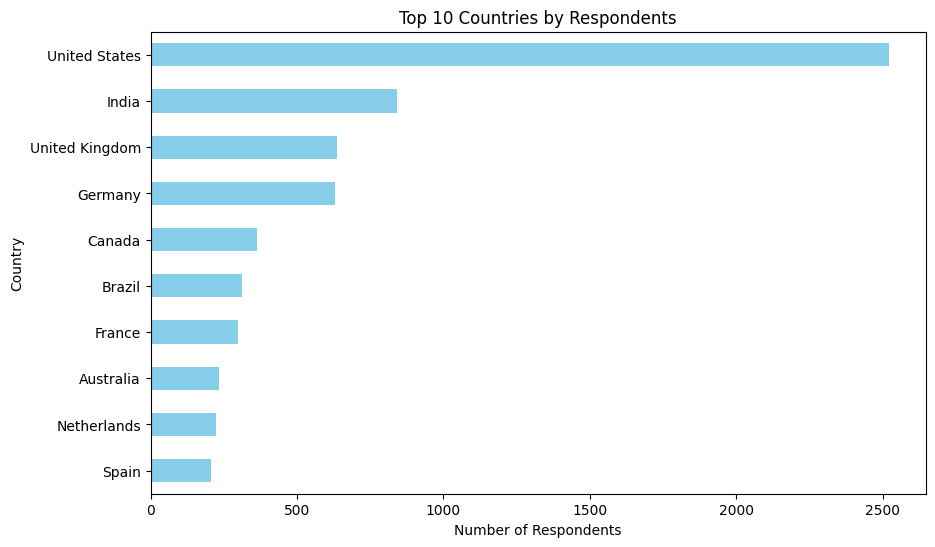

In [21]:
# Kiểm tra chính xác tên các cột hiện có để tránh KeyError
print("Danh sách các cột hiện có:", df_final_project.columns.tolist())

top_countries = df_final_project['country'].value_counts().head(10)

top_countries.plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title('Top 10 Countries by Respondents')
plt.xlabel('Number of Respondents')
plt.ylabel('Country')
plt.gca().invert_yaxis() 
plt.show()

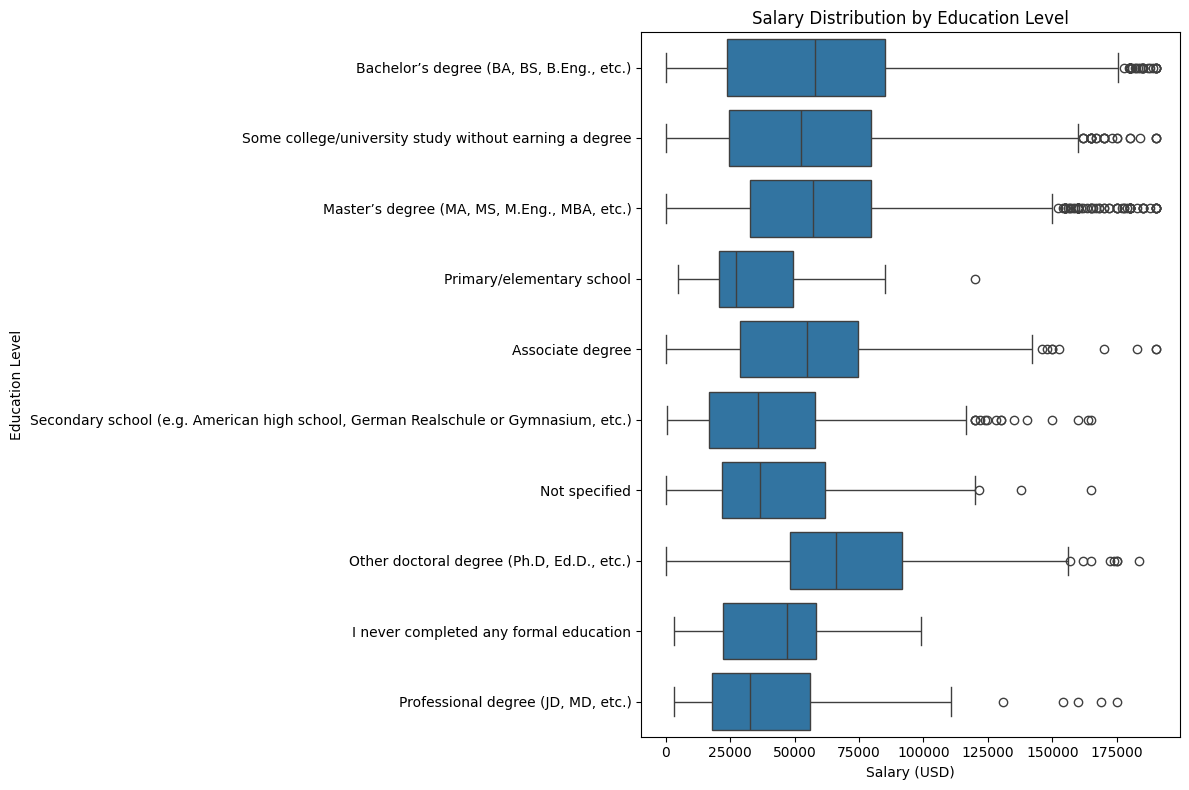

In [20]:
plt.figure(figsize=(12, 8))

# Sửa thành chữ thường: convertedcomp và edlevel
sns.boxplot(x='convertedcomp', y='edlevel', data=df_final_project)

plt.title('Salary Distribution by Education Level')
plt.xlabel('Salary (USD)')
plt.ylabel('Education Level')

# Thêm lệnh này để các nhãn trên trục Y không bị lấn vào biểu đồ
plt.tight_layout() 
plt.show()

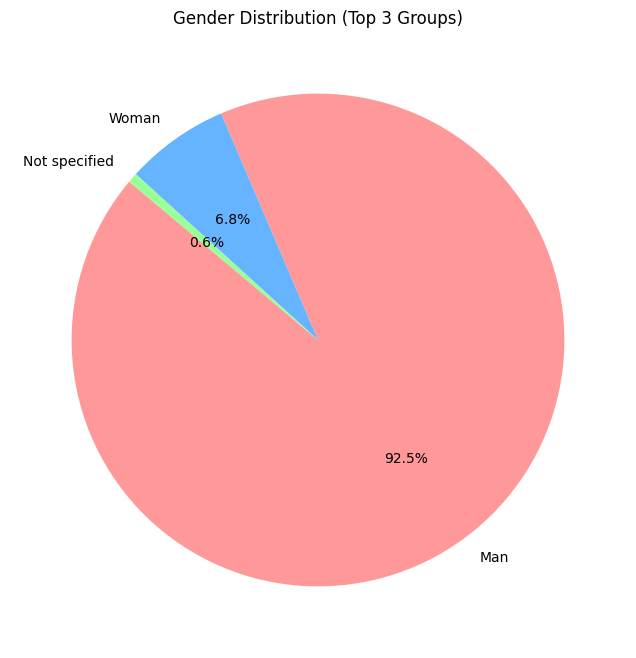

In [19]:
# Lấy 3 nhóm có số lượng đông nhất
gender_counts = df_final_project['gender'].value_counts().head(3) 

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
gender_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['#ff9999','#66b3ff','#99ff99'] # Thêm màu sắc cho đẹp
)

plt.title('Gender Distribution (Top 3 Groups)')
plt.ylabel('') # Ẩn nhãn trục Y để biểu đồ cân đối
plt.show()

5. Save Clear Data Into Database To Visiualization 

In [ ]:
# ==========================================
# 1. THIẾT LẬP KẾT NỐI
# ==========================================
server = 'DESKTOP-MV8RPS5'
database = 'VTI'
source_table = 'final_project'       # Bảng gốc bạn đã import thủ công
target_table = 'final_project_cleaned' # Bảng mới sau khi đã clean

connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
    f"TrustServerCertificate=yes;"
)

params = urllib.parse.quote_plus(connection_string)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# ==========================================
# 2. LOAD DỮ LIỆU TỪ SQL VÀO PYTHON (Định nghĩa lại df_final_project)
# ==========================================
print("Đang tải dữ liệu từ SQL Server...")
query = f"SELECT * FROM [dbo].[{source_table}]"
df_final_project = pd.read_sql(query, engine)
print(f"Đã tải xong: {df_final_project.shape}")

# ==========================================
# 3. KÍCH HOẠT CHẾ ĐỘ SIÊU TỐC (FAST_EXECUTEMANY)
# ==========================================
@event.listens_for(engine, "connect")
def receive_connect(dbapi_connection, connection_record):
    cursor = dbapi_connection.cursor()
    cursor.fast_executemany = True
    cursor.close()

# ==========================================
# 4. ĐỊNH NGHĨA KIỂU DỮ LIỆU ĐỂ CHỐNG LỖI TRUNCATION
# ==========================================
dtype_dict = {}
long_text_cols = ['devtype', 'languageworkedwith', 'platformworkedwith', 'ethnicity', 'devenviron']

for col in df_final_project.columns:
    if col.lower() in long_text_cols:
        # Ép kiểu NVARCHAR(MAX)
        dtype_dict[col] = types.NVARCHAR(length=None) 

# ==========================================
# 5. ĐẨY DỮ LIỆU NGƯỢC LẠI SQL
# ==========================================
print(f"Đang đẩy {len(df_final_project)} dòng vào bảng {target_table}...")

try:
    df_final_project.to_sql(
        name=target_table, 
        con=engine, 
        if_exists='replace', 
        index=False, 
        dtype=dtype_dict,
        chunksize=None 
    )
    print(f"--- THÀNH CÔNG! Đã lưu vào bảng: {target_table} ---")
except Exception as e:
    print(f"--- THẤT BẠI! Lỗi: {e} ---")

Đang tải dữ liệu từ SQL Server...
Đã tải xong: (11552, 85)
Đang đẩy 11552 dòng vào bảng final_project_cleaned...
--- THÀNH CÔNG! Đã lưu vào bảng: final_project_cleaned ---
